# <a href="https://mipt-stats.gitlab.io/courses/ad_mipt.html">Phystech@DataScience</a>
## Профильное задание № 1 для направления "биология"

**Правила:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_pds_bot`.
* Дедлайн **15 мая в 23:00**. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно ноутбук в формате `ipynb` и все фотографии, если пишете теоретическую часть от руки.
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него.

-----




**Работа Закировой Марфы, Б06-907**

# Применение линейных моделей для анализа дифференциальной экспрессии генов

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps
from tqdm.notebook import tqdm
from statsmodels.sandbox.stats.multicomp import multipletests

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Попробуем воспроизвести процесс обработки данных настоящего научного эксперимента. Предоставлены данные об экспресси генов в различных образцах тканей 18 больных колоректальным раком. Для каждого были собраны образцы здоровой ткани прямой кишки, опухоли и метастаз в различные органы. Задача &mdash; понять, как же отличается экспрессия в этих образцах и дисрегуляция каких генов лежит в основе заболевания. 

В этой задаче мы будем использовать данные из  этой [статьи](https://pubmed.ncbi.nlm.nih.gov/25049118/). 


#### 0. Загрузка данных

In [2]:
raw_data = pd.read_csv("http://genomedata.org/gen-viz-workshop/intro_to_deseq2/tutorial/E-GEOD-50760-raw-counts.tsv", sep = "\t")
raw_data.head()

,Gene ID,Gene Name,SRR975551,SRR975552,SRR975553,SRR975554,SRR975555,SRR975556,SRR975557,SRR975558,...,SRR975595,SRR975596,SRR975597,SRR975598,SRR975599,SRR975600,SRR975601,SRR975602,SRR975603,SRR975604
0,ENSG00000000003,TSPAN6,6617,1352,1492,3390,1464,1251,207,1333,...,2786,1717,1691,6192,722,680,2608,2436,1739,2134
1,ENSG00000000005,TNMD,69,1,20,23,12,4,20,2,...,18,7,10,40,14,1,16,0,2,7
2,ENSG00000000419,DPM1,2798,714,510,1140,1667,322,273,621,...,852,1095,1066,1273,405,597,974,1000,1287,1250
3,ENSG00000000457,SCYL3,486,629,398,239,383,290,164,452,...,244,156,256,422,95,255,331,165,347,349
4,ENSG00000000460,C1orf112,466,342,73,227,193,35,38,184,...,121,105,172,293,73,148,180,160,288,100


Каждый столбец в этой таблице соответствует одному из образцов, а каждый ряд &mdash; определенному транскрипту.  
Для того, чтобы понять, что есть что, нужно загрузить таблицу с аннотацией.

In [3]:
sampleData = pd.read_csv("http://genomedata.org/gen-viz-workshop/intro_to_deseq2/tutorial/E-GEOD-50760-experiment-design.tsv",  sep = "\t")
sampleData.head()

,Run,Sample Characteristic[biopsy site],Sample Characteristic Ontology Term[biopsy site],Sample Characteristic[disease],Sample Characteristic Ontology Term[disease],Sample Characteristic[disease staging],Sample Characteristic Ontology Term[disease staging],Sample Characteristic[individual],Sample Characteristic Ontology Term[individual],Sample Characteristic[organism],Sample Characteristic Ontology Term[organism],Sample Characteristic[organism part],Sample Characteristic Ontology Term[organism part],Factor Value[biopsy site],Factor Value Ontology Term[biopsy site],Analysed
0,SRR975551,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,colorectal cancer,http://www.ebi.ac.uk/efo/EFO_0005842,Stage IV Colorectal Cancer,NaN,AMC_2,NaN,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,colon,http://purl.obolibrary.org/obo/UBERON_0001155,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,Yes
1,SRR975552,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,colorectal cancer,http://www.ebi.ac.uk/efo/EFO_0005842,Stage IV Colorectal Cancer,NaN,AMC_3,NaN,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,colon,http://purl.obolibrary.org/obo/UBERON_0001155,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,Yes
2,SRR975553,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,colorectal cancer,http://www.ebi.ac.uk/efo/EFO_0005842,Stage IV Colorectal Cancer,NaN,AMC_5,NaN,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,colon,http://purl.obolibrary.org/obo/UBERON_0001155,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,Yes
3,SRR975554,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,colorectal cancer,http://www.ebi.ac.uk/efo/EFO_0005842,Stage IV Colorectal Cancer,NaN,AMC_6,NaN,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,colon,http://purl.obolibrary.org/obo/UBERON_0001155,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,Yes
4,SRR975555,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,colorectal cancer,http://www.ebi.ac.uk/efo/EFO_0005842,Stage IV Colorectal Cancer,NaN,AMC_7,NaN,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,colon,http://purl.obolibrary.org/obo/UBERON_0001155,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,Yes


#### 1. Предобработка данных



Образцы бывают следующих типов: 

In [4]:
sampleData["Sample Characteristic[biopsy site]"].unique()

array(['primary tumor', 'normal',
       'colorectal cancer metastatic in the liver'], dtype=object)

Для генов  TREM1 and CTGF постройте боксплоты для выборок образцов каждого типа. Один ген стройте на одном графике. Сделайте выводы.

In [5]:
prim_tum_names = sampleData[sampleData['Sample Characteristic[biopsy site]'] == 'primary tumor']['Run'].to_numpy()
normal_names = sampleData[sampleData['Sample Characteristic[biopsy site]'] == 'normal']['Run'].to_numpy()
cancer_names = sampleData[sampleData['Sample Characteristic[biopsy site]'] == 'colorectal cancer metastatic in the liver']['Run'].to_numpy()

In [6]:
def not_raw_gene(gene):
  """Возвращает таблицу данных для одного гена для трех типов образцов. Она нужна для корректного построения boxplot'a"""
  prim_tum = raw_data[raw_data['Gene Name'] == gene][prim_tum_names].T
  prim_tum['type'] = ['primary tumor' for _ in range(prim_tum.shape[0])]
  normal = raw_data[raw_data['Gene Name'] == gene][normal_names].T
  normal['type'] = ['normal' for _ in range(normal.shape[0])]
  cancer = raw_data[raw_data['Gene Name'] == gene][cancer_names].T
  cancer['type'] = ['cancer metastatic' for _ in range(cancer.shape[0])]
  res  = pd.concat([prim_tum, normal, cancer])
  res.columns = ['values', 'type']
  return res

Text(0.5, 0, 'Type')

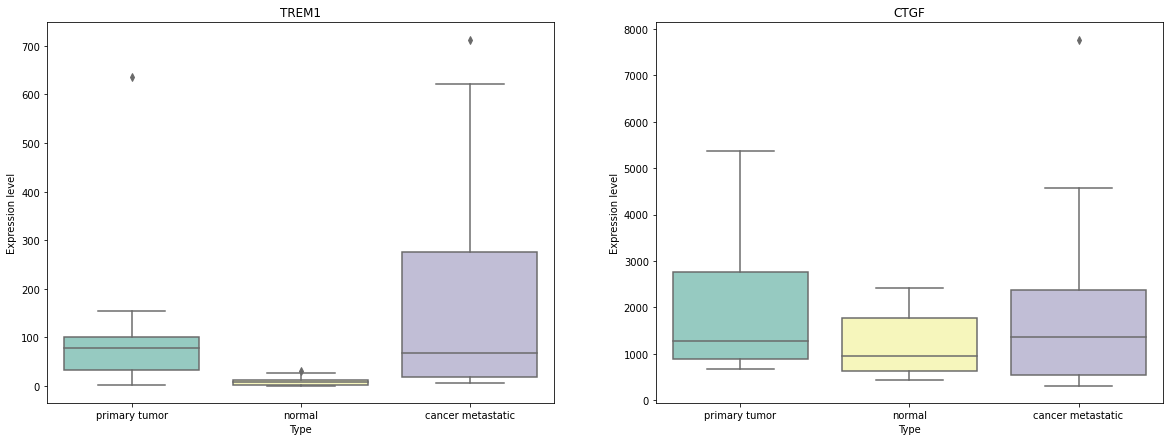

In [7]:
trem1 = not_raw_gene('TREM1')
ctgf = not_raw_gene('CTGF')

plt.figure(figsize=(20, 7))
plt.subplot(121)
sns.boxplot(x="type", y =trem1['values'], data=trem1, palette="Set3")
plt.title('TREM1')
plt.ylabel('Expression level')
plt.xlabel('Type')

plt.subplot(122)
sns.boxplot(x="type", y =ctgf['values'], data=ctgf, palette="Set3")
plt.title('CTGF')
plt.ylabel('Expression level')
plt.xlabel('Type')

**Увеличение среднего уровня экспрессии TREM1 можно использовать как потенциальный маркер развития рака, по увеличению его дисперсии можно судить о наличии метастазов. При этом с развитием рака эксперессия гена CTGF меняется не так сильно.**

  
Важно: для дальнейшей работы необходимо использовать транскрипты в формате ENSG00...., а не названия генов, так как названия могут дублироваться из-за соответствия нескольких транскриптов одному гену. Gene id в формате ENSG00* присвоены базой данных [ensembl](https://www.ensembl.org/Homo_sapiens/Info/Index), где собрано большое количество стандартизированной информации про каждый из генов и их транскриптов. Названия нам понадобятся для интерпретации результатов, поэтому создайте на будущее словарь, где ключи &mdash; индивидуальные ID в системе ensembl (Gene ID), а значения &mdash; их названия (Gene Name).

In [8]:
gene_names = {}
for key in tqdm(raw_data["Gene ID"]):
  gene_names[key] = raw_data[raw_data["Gene ID"] == key]['Gene Name'].to_numpy()[0]

gene_names

  0%|          | 0/65217 [00:00<?, ?it/s]

{'ENSG00000000003': 'TSPAN6',
 'ENSG00000000005': 'TNMD',
 'ENSG00000000419': 'DPM1',
 'ENSG00000000457': 'SCYL3',
 'ENSG00000000460': 'C1orf112',
 'ENSG00000000938': 'FGR',
 'ENSG00000000971': 'CFH',
 'ENSG00000001036': 'FUCA2',
 'ENSG00000001084': 'GCLC',
 'ENSG00000001167': 'NFYA',
 'ENSG00000001460': 'STPG1',
 'ENSG00000001461': 'NIPAL3',
 'ENSG00000001497': 'LAS1L',
 'ENSG00000001561': 'ENPP4',
 'ENSG00000001617': 'SEMA3F',
 'ENSG00000001626': 'CFTR',
 'ENSG00000001629': 'ANKIB1',
 'ENSG00000001630': 'CYP51A1',
 'ENSG00000001631': 'KRIT1',
 'ENSG00000002016': 'RAD52',
 'ENSG00000002079': 'MYH16',
 'ENSG00000002330': 'BAD',
 'ENSG00000002549': 'LAP3',
 'ENSG00000002586': 'CD99',
 'ENSG00000002587': 'HS3ST1',
 'ENSG00000002726': 'AOC1',
 'ENSG00000002745': 'WNT16',
 'ENSG00000002746': 'HECW1',
 'ENSG00000002822': 'MAD1L1',
 'ENSG00000002834': 'LASP1',
 'ENSG00000002919': 'SNX11',
 'ENSG00000002933': 'TMEM176A',
 'ENSG00000003056': 'M6PR',
 'ENSG00000003096': 'KLHL13',
 'ENSG00000003

Для последующего анализа  будем использовать только образцы типов control и primary tumour. Создайте матрицу значений экспрессии (gene count matrix) для образцов с этими типами. Каждый столбец должен соответствовать интересующему нас образцу, а ряд &mdash; гену, в ячейке матрицы стоит значение уровня экспрессии.

In [9]:
rawCounts = raw_data[[  'Gene ID', *prim_tum_names, *normal_names]]
rawCounts

,Gene ID,SRR975551,SRR975552,SRR975553,SRR975554,SRR975555,SRR975556,SRR975557,SRR975558,SRR975559,...,SRR975578,SRR975579,SRR975580,SRR975581,SRR975582,SRR975583,SRR975584,SRR975585,SRR975586,SRR975587
0,ENSG00000000003,6617,1352,1492,3390,1464,1251,207,1333,2126,...,1008,310,2704,674,1121,1776,981,1185,2012,3190
1,ENSG00000000005,69,1,20,23,12,4,20,2,3,...,10,13,21,5,19,3,10,7,2,6
2,ENSG00000000419,2798,714,510,1140,1667,322,273,621,1031,...,271,213,783,268,467,452,419,473,607,1274
3,ENSG00000000457,486,629,398,239,383,290,164,452,172,...,243,159,324,257,360,409,310,430,248,314
4,ENSG00000000460,466,342,73,227,193,35,38,184,174,...,21,17,131,52,57,86,70,65,79,251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65212,ENSG00000281918,0,0,0,0,0,0,1,0,0,...,0,0,2,0,0,1,0,0,2,0
65213,ENSG00000281919,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65214,ENSG00000281920,0,1,0,0,0,0,0,0,1,...,0,1,1,0,0,0,0,1,0,0
65215,ENSG00000281921,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
rawCounts.head()

,Gene ID,SRR975551,SRR975552,SRR975553,SRR975554,SRR975555,SRR975556,SRR975557,SRR975558,SRR975559,...,SRR975578,SRR975579,SRR975580,SRR975581,SRR975582,SRR975583,SRR975584,SRR975585,SRR975586,SRR975587
0,ENSG00000000003,6617,1352,1492,3390,1464,1251,207,1333,2126,...,1008,310,2704,674,1121,1776,981,1185,2012,3190
1,ENSG00000000005,69,1,20,23,12,4,20,2,3,...,10,13,21,5,19,3,10,7,2,6
2,ENSG00000000419,2798,714,510,1140,1667,322,273,621,1031,...,271,213,783,268,467,452,419,473,607,1274
3,ENSG00000000457,486,629,398,239,383,290,164,452,172,...,243,159,324,257,360,409,310,430,248,314
4,ENSG00000000460,466,342,73,227,193,35,38,184,174,...,21,17,131,52,57,86,70,65,79,251


Мы пропустим большую часть препроцессинга. Тем не менее, изучать изменения в экспрессии генов, которые практически не экспрессируются особо не имеет смысла. Поэтому необходимо удалить из таблицы все транскрипты, где суммарная экспрессия меньше 5:

In [11]:
index_to_drop = rawCounts.index[rawCounts.sum(axis = 1) < 5]
rawCounts = rawCounts.drop(index_to_drop)
rawCounts

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


,Gene ID,SRR975551,SRR975552,SRR975553,SRR975554,SRR975555,SRR975556,SRR975557,SRR975558,SRR975559,...,SRR975578,SRR975579,SRR975580,SRR975581,SRR975582,SRR975583,SRR975584,SRR975585,SRR975586,SRR975587
0,ENSG00000000003,6617,1352,1492,3390,1464,1251,207,1333,2126,...,1008,310,2704,674,1121,1776,981,1185,2012,3190
1,ENSG00000000005,69,1,20,23,12,4,20,2,3,...,10,13,21,5,19,3,10,7,2,6
2,ENSG00000000419,2798,714,510,1140,1667,322,273,621,1031,...,271,213,783,268,467,452,419,473,607,1274
3,ENSG00000000457,486,629,398,239,383,290,164,452,172,...,243,159,324,257,360,409,310,430,248,314
4,ENSG00000000460,466,342,73,227,193,35,38,184,174,...,21,17,131,52,57,86,70,65,79,251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65198,ENSG00000281904,1,1,2,1,0,3,2,3,2,...,0,2,3,1,1,2,1,2,2,1
65203,ENSG00000281909,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
65206,ENSG00000281912,15,8,6,5,9,17,4,10,7,...,7,9,12,10,11,20,9,11,13,9
65212,ENSG00000281918,0,0,0,0,0,0,1,0,0,...,0,0,2,0,0,1,0,0,2,0


Как изменилось количество исследуемыех нами генов?

**Cравнивая размеры rawCounts до и после редактирования видим, что генов стало почти в два раза меньше**

Для каждого гена оцените дисперсию. Постройте гистограмму распределения значений.

In [12]:
vars = {}
vars['Gene ID'] = rawCounts['Gene ID'].to_numpy()
vars['Variances'] = rawCounts.var(axis = 1).to_numpy()
vars = pd.DataFrame(vars)
vars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


,Gene ID,Variances
0,ENSG00000000003,1.608939e+06
1,ENSG00000000005,1.458544e+02
2,ENSG00000000419,2.482014e+05
3,ENSG00000000457,1.492261e+04
4,ENSG00000000460,9.525030e+03
...,...,...
34224,ENSG00000281904,1.141141e+00
34225,ENSG00000281909,3.258258e-01
34226,ENSG00000281912,1.713363e+01
34227,ENSG00000281918,3.558559e-01


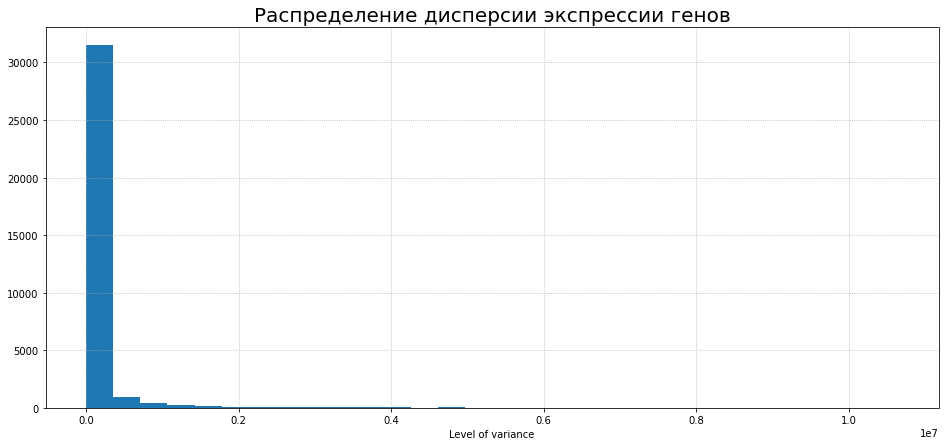

In [13]:
plt.figure(figsize=(16, 7))
vars['Variances'].hist(bins = 30, range = [0,np.quantile(vars.Variances, 0.99)]) #построим гистограмму невелируя выбросы
plt.title(r'Распределение дисперсии экспрессии генов', fontsize=20)
plt.xlabel('Level of variance')
plt.grid(ls=':')
plt.show()

**Видим, что для очеь большого числа генов дисперсия экспрессии мала.**

Отсортируем по значению дисперсии и возьмем 5000 генов с наибольшим разбросом дисперсии.

In [14]:
vars = vars.sort_values(by=['Variances'], ascending=False)
vars2 = vars.iloc[:5000,:]
vars2

,Gene ID,Variances
16632,ENSG00000198804,8.221629e+10
10766,ENSG00000163631,1.894572e+10
16679,ENSG00000198886,1.440221e+10
17840,ENSG00000210082,1.116738e+10
16710,ENSG00000198938,8.172536e+09
...,...,...
8720,ENSG00000147202,1.124870e+05
12005,ENSG00000168522,1.124739e+05
24496,ENSG00000243766,1.124714e+05
4124,ENSG00000113460,1.124553e+05


**Первая гистограмма получилось не очень информативной, построим для данных в начальных корзинах, чтобы понимать величину скачка дисперсии.**

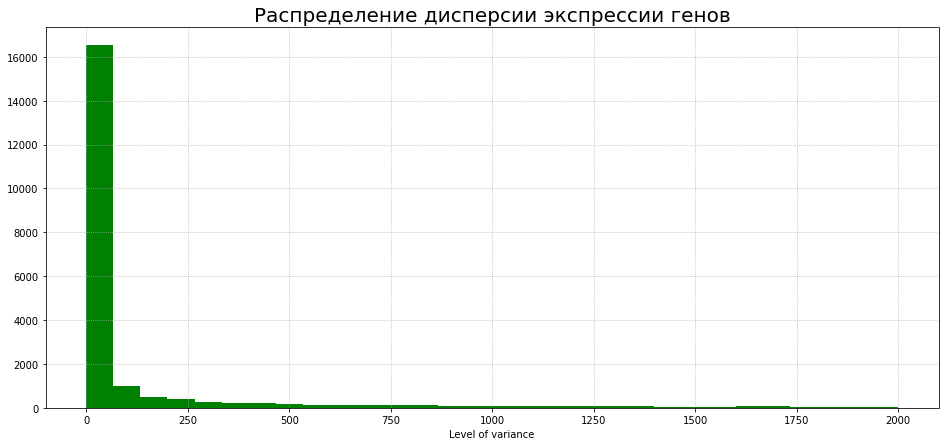

In [15]:
plt.figure(figsize=(16, 7))
vars[vars['Variances'] < 2000]['Variances'].hist(bins = 30, color = 'g') #построим гистограмму невелируя выбросы
plt.title(r'Распределение дисперсии экспрессии генов', fontsize=20)
plt.xlabel('Level of variance')
plt.grid(ls=':')
plt.show()

В случае, если нам не хватает вычислительных ресурсов построить модели для каждого из транскриптов в данных, можно выбрать какую-то подвыборку. Можно случайно (только в учебных целях!), можно &mdash; используя какую-то  метрику, например дисперсию. Является ли дисперсия оптимальной метрикой? Почему? Если считаете, что нет &mdash; предложите свою альтернативу.

**Если у какого - то гена большая дисперсия, то значит уровень его экспресии меняется значительно. Нам нет смысла искать корреляции между развитием рака и генами, чья экспрессия при этом меняется слабо.**

#### 2. Построение линейной модели

Используя модуль **sklearn.linear_model.LinearRegression** построим для гена TREM1 самую простую линейную регрессию, используя дизайн $y = x \theta$, где $y$ &mdash; значение экспрессии гена, а $x$ &mdash; параметр, обозначающий, является ли образец контролем или раковым.

**Заметим, что в нативном виде x - является категориальной переменной, сделаем сопоставление:** 

**контроль: x = 1, рак(первичный и метасиазированный): x =  -1**

In [16]:
y  = np.array([*trem1[trem1['type'] == 'normal']['values'], *trem1[trem1['type'] != 'normal']['values']]).reshape(-1,1)
x = np.array([*[1 for _ in trem1[trem1['type'] == 'normal']['type']],*[-1 for _ in trem1[trem1['type'] != 'normal']['type']]]).reshape(-1,1)

Постройте модель:

In [17]:
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,shuffle=True, stratify=x)
#делаю стратификацию чтобы итоговое соотношение раковых и нормальных классов в тестовой и тренировочной выбоке было одинаковым
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


Визуализируйте, как эта модель ложится на данные.

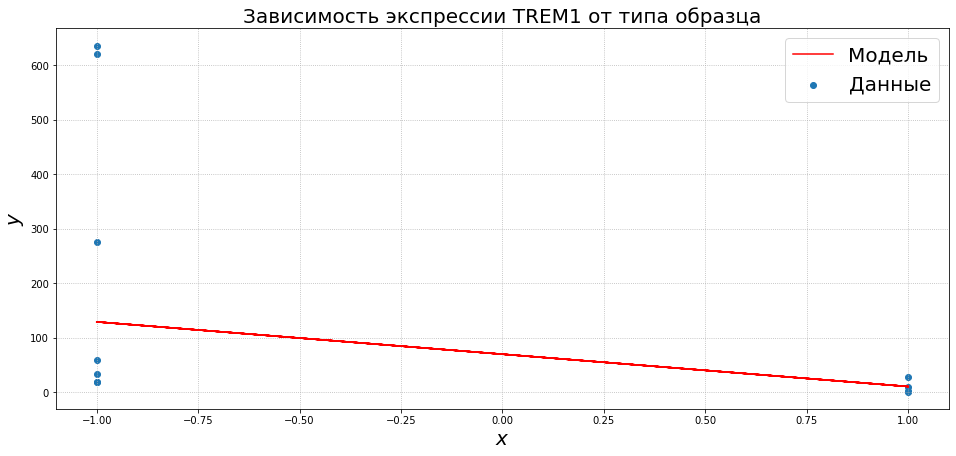

In [22]:
plt.figure(figsize=(16,7))
plt.scatter(X_test, y_test, label = 'Данные')
plt.plot(X_test, y_pred, label = 'Модель',color = 'r')
plt.xlabel(r'$x$', fontsize=20)
plt.ylabel(r'$y$', fontsize=20)
plt.title(r'Зависимость экспрессии TREM1 от типа образца', fontsize=20)
plt.legend(fontsize=20, loc=0)
plt.grid(ls=':')
plt.show()

Реализуйте построение линейной модели как функцию и рассчитайте коэффицент для каждого гена. Если это слишком долго на вашем ноутбуке, возьмите подвыборку определенного размера (1000, 5000, 10000 &mdash; сколько получится)  либо используя предложенный вами критерий, либо случайно.

In [23]:
def not_raw_gene1(gene_id):
  """В предыдущей такой функции было обращение по именам, тут по ID"""
  prim_tum = raw_data[raw_data['Gene ID'] == gene_id][prim_tum_names].T
  prim_tum['type'] = ['primary tumor' for _ in range(prim_tum.shape[0])]
  normal = raw_data[raw_data['Gene ID'] == gene_id][normal_names].T
  normal['type'] = ['normal' for _ in range(normal.shape[0])]
  cancer = raw_data[raw_data['Gene ID'] == gene_id][cancer_names].T
  cancer['type'] = ['cancer metastatic' for _ in range(cancer.shape[0])]
  res  = pd.concat([prim_tum, normal, cancer])
  res.columns = ['values', 'type']
  return res

In [24]:
def get_gene_coef(gene_id, group = None):
  res = not_raw_gene1(gene_id)
  if group != None: 
    y  = np.array([*res[res['type'] == 'normal']['values'], *res[res['type'] == group]['values']]).reshape(-1,1)
    x = np.array([*[1 for _ in res[res['type'] == 'normal']['type']],*[-1 for _ in res[res['type'] == group]['type']]]).reshape(-1,1)
  else:  #если не передали группу с которой сравниваем контроль, то сравниваем со всеми раковыми образцами: и метастазированными и первичными
    y  = np.array([*res[res['type'] == 'normal']['values'], *res[res['type'] != 'normal']['values']]).reshape(-1,1)
    x = np.array([*[1 for _ in res[res['type'] == 'normal']['type']],*[-1 for _ in res[res['type'] != 'normal']['type']]]).reshape(-1,1)
  model = LinearRegression()
  model.fit(x, y)
  return model.coef_[0]

In [25]:
coefs = {}
for gene_id in tqdm(vars2['Gene ID']):
  coefs[gene_id] = get_gene_coef(gene_id)


  0%|          | 0/5000 [00:00<?, ?it/s]

In [26]:
coefs = pd.Series(coefs)
coefs

ENSG00000198804      [61613.06992481203]
ENSG00000163631     [-42685.30526315791]
ENSG00000198886    [-11430.414285714282]
ENSG00000210082     [29543.975187969932]
ENSG00000198938    [-1918.7112781954856]
                           ...          
ENSG00000147202     [-120.0571428571429]
ENSG00000168522    [-123.50902255639105]
ENSG00000243766      [78.22255639097745]
ENSG00000113460    [-171.40676691729328]
ENSG00000137960     [121.60751879699248]
Length: 5000, dtype: object

In [27]:
## Example
#в нативном виде странно работал, подредактировала для читабельности
rawCountSubset = rawCounts.sample(n = 100)
res = pd.Series(rawCountSubset['Gene ID'].apply(get_gene_coef))
res.index = rawCountSubset['Gene ID']
res

Gene ID
ENSG00000162739       [10.096240601503759]
ENSG00000092531        [54.26015037593987]
ENSG00000228661      [0.05187969924812039]
ENSG00000128815        [32.87894736842107]
ENSG00000100417       [59.924812030075195]
                            ...           
ENSG00000196951    [-0.045112781954887285]
ENSG00000127220      [-1.5827067669172934]
ENSG00000259405      [0.09924812030075188]
ENSG00000254990       [-4.705263157894738]
ENSG00000234737      [0.06315789473684216]
Name: Gene ID, Length: 100, dtype: object

#### 3. Сделаем выводы

Какие гены обладают наибольшей разницей между злокачественным образцом и контролем? Что означает, является коэффицент для гена в линейной регрессии положительным или отрицательным? 
Для 5 генов с самым большими по модулю коэффицентами выведите имена и, используя Интернет, опишите их функцию.

**Если разница большая, то значения экспрессии генов для рака (или контроля) сильно большие, а для контроля (или рака соответственно) сильно маленькие, то есть их распределение в координатах y(x) из линейной модели очень крутое $⇒$ угловой коэффициент большой отрицательный (положительный сооотвественно)  $⇒$  в любом случае большой по модулю**

In [28]:
coefs = np.abs(coefs)  #берем всё по модулю
coefs = coefs.sort_values(ascending = False)

coefs_abs = np.abs(coefs).sort_values(ascending = False)
for name_id in coefs_abs.iloc[:5].index:
  print(f'{gene_names[name_id]}: {np.round(coefs[name_id],3)}')

MT-CO1: [61613.07]
ALB: [42685.305]
IGHA2: [40411.407]
PIGR: [37435.902]
JCHAIN: [30156.717]


**MT-CO1** - Способствует повышению активности цитохром-с оксидазы. Предсказано, что он участвует в транспорте электронов, транспорте протонов и митохондриальном транспорте электронов, превращении цитохрома с в кислород.

**ALB** - Этот ген кодирует наиболее распространенные белки в крови человека. Этот белок участвует в регуляции коллоидно-осмотического давления плазмы крови и действует как белок-носитель для широкого спектра эндогенных молекул, включая гормоны, жирные кислоты и метаболиты, а также экзогенные лекарственные средства.


**IGHA2** - Способствует связыванию рецепторов иммуноглобулинов. Участвует в антибактериальном гуморальном ответе, клубочковой фильтрации и положительной регуляции дыхательного выброса. Расположен во внеклеточном пространстве.


**PIGR** - Кодируемый поли-Ig рецептор связывает молекулы полимерного иммуноглобулина на базолатеральной поверхности эпителиальных клеток; затем комплекс транспортируется через клетку для секреции на апикальной поверхности.


**JCHAIN** - Способствует нескольким функциям, включая активность связывания с рецептором иммуноглобулина; активность связывания с пептидогликаном; и активность связывания с фосфатидилхолином.

Не забывайте, что мы с вами работали с игрушечным примером на сырых данных, еще и на подвыборке, поэтому результат скорее всего не будет практически значимым. В реальной жизни модели  сложнее, а предобработка данных займет столько же времени, как и сам анализ, если не в два раза больше.

Если интересно, посмотрите на туториалы для таких пакетов как limma/DeSeq2/diffxpy, чтобы понять разницу :) 

#### 4. Задача со звездочкой

Для топ 100 генов из пункта 3 повторите анализ, но теперь сравнивая экспрессию между образцами из контрольной группы и метастаз. Сравните полученные коэффиценты.

In [29]:
coefs2 = {}
for gene_id in tqdm(coefs.iloc[:100].index):
  coefs2[gene_id] = get_gene_coef(gene_id, group = 'cancer metastatic')
coefs2 = pd.Series(coefs2)
coefs2_abs = np.abs(coefs2).sort_values(ascending = False)
for name_id in coefs2_abs.iloc[:5].index:
  print(f'{gene_names[name_id]}: {np.round(coefs2[name_id],3)}')

  0%|          | 0/100 [00:00<?, ?it/s]

ALB: [-111228.693]
MT-CO1: [56285.39]
PIGR: [47521.492]
IGHA2: [45455.715]
SERPINA1: [-35905.964]


In [30]:
coefs3 = {}
for gene_id in tqdm(coefs.iloc[:100].index):
  coefs3[gene_id] = get_gene_coef(gene_id, group = 'primary tumor')
coefs3 = pd.Series(coefs3)
coefs3_abs = np.abs(coefs3).sort_values(ascending = False)
for name_id in coefs3_abs.iloc[:5].index:
  print(f'{gene_names[name_id]}: {np.round(coefs3[name_id],3)}')

  0%|          | 0/100 [00:00<?, ?it/s]

MT-CO1: [66644.768]
MT-RNR2: [37474.512]
IGHA2: [35647.338]
PIGR: [27910.621]
JCHAIN: [26444.196]


**Если сравнивать только coefs и coefs2, то видим отличие только в экспресии SERPINA1 и JCHAIN, сравнивать это немного странно, так как данные из coefs2 уже содержаться в coefs(так как при выполнении заданий 2-3 было непонятно что такое раковые образцы), раковые образцы == первичные и метастазированные. Лучше сравнить coefs2 и coefs3, 2 - для метастазированных, 3 - первичных. Как видим, с развитием рака экспрессия MT-CO1, IGHA2, PIGR остается высокой в контроле, относительно рака. При метастазировании увеличивается экспрессия ALB и SERPINA1.**

#### 5. Построение volcano plot

Хорошим способом визуализации данных дифференциальной экспрессии является так называемый `volcano plot`, по осям которого откладываются $log_2(fold\:change)$ и $-log_{10}(p\:value)$. Fold change показывает, во сколько изменился уровень экспрессии относительно контрольной группы, а p value находится с помощью t-критерия. Таким образом, на volcano plot можно очень удобно визуально наблюдать гены, для которых p value больше заранее выбранного уровня значимости. При этом fold change позволяет выбрать те гены, уровень экспрессии которых изменяется в определенное число раз и больше.

Попробуйте построить `volvano plot` для предоставленных данных. Отобразите на графике первые 300-500 генов в упорядоченном по возрастанию p value массиве (по убыванию "значимости"). Нарисуйте вертикальные линии, соответствующие fold change 1/2 и 2, горизонтальную линию для выбранного уровня значимости. Покрасьте оверэкспрессированные статистически значимые точки в один цвет, а подавленные (downregulated) - в другой. Подпишите эти гены. Не забудьте про МПГ.

! Вычисления проводите для контрольной группы и опухоли. **Сделайте выводы**.

In [31]:
def p_value(gene_id, group_1, group_2):
    '''
    gene_id: ID гена в ensemble
    group_1: список с образцами определенного вида (напр., нормальная ткань)
    group_2: второй список с образцами определенного вида (напр., опухолевая ткань)
    
    Функция сравнивает уровни экспрессии гена в группах group_1 и group_2
    Возвращает p value, посчитанное с помощью t-критерия
    '''
    res = not_raw_gene1(gene_id)
    sample_1  = np.array(res[res['type'] == group_1]['values']) 
    sample_2 = np.array(res[res['type'] == group_2]['values'])
    return sps.ttest_ind(sample_1, sample_2)[1]  

In [32]:
def fold_change(gene_id, group_1, group_2):
    '''
    Возвращает значение, во сколько средний уровень экспрессии во второй группе
    больше, чем в первой
    '''
    res = not_raw_gene1(gene_id)
    sample_1  = np.array(res[res['type'] == group_1]['values']) 
    sample_2 = np.array(res[res['type'] == group_2]['values'])
  
    return np.mean(sample_2)/np.mean(sample_1)

**На самом деле, я не очень понимаю почему здесь надо использоват именно Т-критерий, если он обычно для нормальных данных, а метод volcano plot вроде универсальный и должен подходить для генов с различным распределением. Образцы обычно берутся из разных организмов $\Rightarrow$ используем t-критерий для независимых выборок.**

In [33]:
volcano = {}
volcano['name'] = raw_data['Gene Name'].iloc[:500]
volcano['folds'] = np.array([fold_change(name_id, 'normal','primary tumor') for name_id in rawCounts['Gene ID'].iloc[:500]]) 
volcano['p_vals'] = np.array([p_value(name_id, 'normal','primary tumor') for name_id in rawCounts['Gene ID'].iloc[:500]])
volcano['p_vals'] = multipletests(volcano['p_vals'], method = 'holm')[1]
volcano = pd.DataFrame(volcano)
volcano = volcano.sort_values(by=['p_vals'])
volcano = volcano.iloc[0:300,:]  #выберем первые 300 с минимальным p-value


In [34]:
volcano['type'] = [*['Значим' for _ in range(volcano['p_vals'][volcano['p_vals'] <0.05].shape[0])], *['Незначим' for _ in range(volcano['p_vals'][volcano['p_vals'] >= 0.05].shape[0])]]
volcano['fold style'] = [0 for _ in range(volcano.shape[0])]
for i,fold in enumerate(volcano['folds']):
  if fold > 2:
    volcano['fold style'].iloc[i] = 'Up'
  if fold < 1/2:
    volcano['fold style'].iloc[i] = 'Down'
  if 1/2 <= fold <= 2:
    volcano['fold style'].iloc[i] = 'Ok'


to_annot_up = volcano[(volcano['fold style']== 'Up') &(volcano['type']== 'Значим')]
to_annot_down = volcano[(volcano['fold style']== 'Down') &(volcano['type']== 'Значим')]


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


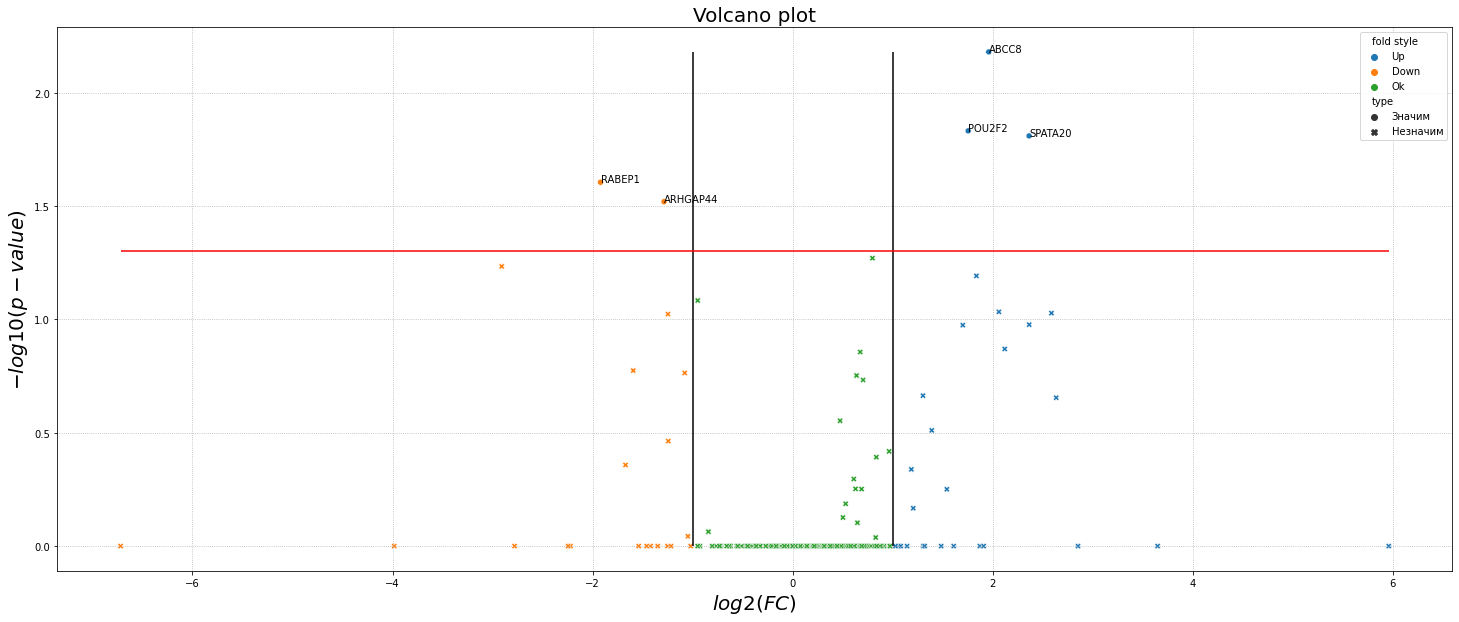

In [36]:
plt.figure(figsize=(25,10))

sns.scatterplot(x=np.log2(volcano['folds']), y = -np.log10(volcano['p_vals']), style=volcano["type"], hue=volcano["fold style"] )

plt.vlines(np.log2(1/2),0, np.max(-np.log10(volcano['p_vals'])), color='black')
plt.vlines(np.log2(2),0, np.max(-np.log10(volcano['p_vals'])), color='black')
plt.hlines(-np.log10(0.05),np.min(np.log2(volcano['folds'])), np.max(np.log2(volcano['folds'])), color = 'r')
for name in to_annot_up['name']:
  plt.annotate(name, (np.log2(to_annot_up[to_annot_up['name'] == name]['folds']),-np.log10(to_annot_up[to_annot_up['name'] == name]['p_vals'])))
for name in to_annot_down['name']:
  plt.annotate(name, (np.log2(to_annot_down[to_annot_down['name'] == name]['folds']),-np.log10(to_annot_down[to_annot_down['name'] == name]['p_vals'])))

plt.xlabel(r'$log2(FC)$', fontsize=20)
plt.ylabel(r'$-log10(p-value)$', fontsize=20)
plt.title(r'Volcano plot', fontsize=20)
plt.grid(ls=':')
plt.show()

**Вывод:** **Cамые важные гены находятся в правом верхнем углу: проходят пороговые значения FWER и logFC, являются статистически значимыми. Их уровень экспрессии сильно изменился по сравнению с контролем.**